# Chapter 5 — The Carbon system and several useful procedures

**Based on Chapter 5:** J.C.G. Walker, *Numerical Adventures with Geochemical Cycles*, Oxford University Press, 1991.

---

## 5.1 Overview

In Chapter 4 we used a simplified power-law ($pCO_2 \propto DIC^\xi$) to represent the nonlinearity of the ocean carbonate system. Chapter 5 replaces that approximation with the **real chemistry**: the equilibrium speciation of dissolved CO₂ in seawater, governed by two dissociation constants.

Walker introduces several "useful procedures", subroutines that compute the carbonate speciation from any two known parameters (e.g., DIC and alkalinity). These become the building blocks for all subsequent chapters.

### Chapter structure

1. The ocean carbonate system: equilibrium chemistry
2. Computing speciation from DIC and Alkalinity
3. The Bjerrum plot and pH dependence
4. Deriving the Revelle (buffer) factor from first principles
5. Fossil fuel CO₂ uptake with real ocean chemistry

---

## 5.2 The Ocean Carbonate system

When CO₂ dissolves in seawater, it participates in a series of equilibria:

$$
\begin{aligned}
\text{CO}_2(g) &\rightleftharpoons \text{CO}_2(aq) \\
\text{CO}_2(aq) + \text{H}_2\text{O} &\rightleftharpoons \text{H}^+ + \text{HCO}_3^-
\quad &K_1 \\
\text{HCO}_3^- &\rightleftharpoons \text{H}^+ + \text{CO}_3^{2-}
\quad &K_2
\end{aligned}
$$

where $K_1$ and $K_2$ are the first and second dissociation constants of carbonic acid in seawater. Typical values at 25°C, S = 35:

$$
\begin{aligned}
K_1 &\approx 10^{-5.9} \approx 1.3 \times 10^{-6} \text{ mol/kg} \\
K_2 &\approx 10^{-9.0} \approx 1.0 \times 10^{-9} \text{ mol/kg}
\end{aligned}
$$

### Two master variables: DIC and Alkalinity

**Dissolved Inorganic Carbon (DIC):** the total carbon in dissolved form:

$$
\text{DIC} = [\text{CO}_2] + [\text{HCO}_3^-] + [\text{CO}_3^{2-}]
$$

**Carbonate Alkalinity (Alk):** the charge-weighted sum of carbonate species:

$$
\text{Alk} \approx [\text{HCO}_3^-] + 2[\text{CO}_3^{2-}]
$$

(We use the simplified carbonate alkalinity here, neglecting borate and other minor contributions, following Walker's approach.)

Given DIC and Alk, one can compute the full speciation: $[\text{CO}_2]$, $[\text{HCO}_3^-]$, $[\text{CO}_3^{2-}]$, and pH. This is one of Walker's "useful procedures".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import brentq

np.set_printoptions(precision=6, suppress=True)

In [2]:
# ============================================================
# Carbonate system constants (25°C, S=35)
# Following Walker / Broecker & Peng conventions
# ============================================================
K1 = 10**(-5.9)    # First dissociation constant (mol/kg)
K2 = 10**(-9.0)    # Second dissociation constant (mol/kg)
K0 = 3.4e-2        # Henry's law solubility (mol/kg/atm)

print(f"K1 = {K1:.3e} mol/kg  (pK1 = {-np.log10(K1):.1f})")
print(f"K2 = {K2:.3e} mol/kg  (pK2 = {-np.log10(K2):.1f})")
print(f"K0 = {K0:.3e} mol/kg/atm")

K1 = 1.259e-06 mol/kg  (pK1 = 5.9)
K2 = 1.000e-09 mol/kg  (pK2 = 9.0)
K0 = 3.400e-02 mol/kg/atm


---

## 5.3 Useful procedure 1: Speciation from DIC and Alkalinity

Given DIC and Alk, we need to find $[\text{H}^+]$ (and hence all species). The equations to solve simultaneously are:

$$
\begin{aligned}
\text{DIC} &= [\text{CO}_2] + [\text{HCO}_3^-] + [\text{CO}_3^{2-}] \\
\text{Alk} &= [\text{HCO}_3^-] + 2[\text{CO}_3^{2-}] \\
K_1 &= \frac{[\text{H}^+][\text{HCO}_3^-]}{[\text{CO}_2]} \\
K_2 &= \frac{[\text{H}^+][\text{CO}_3^{2-}]}{[\text{HCO}_3^-]}
\end{aligned}
$$

Expressing all species in terms of $h = [\text{H}^+]$ and DIC:

$$
\begin{aligned}
[\text{CO}_2] &= \text{DIC} \cdot \frac{h^2}{h^2 + K_1 h + K_1 K_2} \\
[\text{HCO}_3^-] &= \text{DIC} \cdot \frac{K_1 h}{h^2 + K_1 h + K_1 K_2} \\
[\text{CO}_3^{2-}] &= \text{DIC} \cdot \frac{K_1 K_2}{h^2 + K_1 h + K_1 K_2}
\end{aligned}
$$

Substituting into the alkalinity equation gives a single equation for $h$ that we solve numerically — this is Walker's procedure.

In [3]:
def carbonate_speciation(DIC, Alk, K1=K1, K2=K2):
    """Walker's useful procedure: compute carbonate speciation from DIC and Alk.
    
    Parameters
    ----------
    DIC : float, total dissolved inorganic carbon (mol/kg)
    Alk : float, carbonate alkalinity (mol/kg)
    
    Returns
    -------
    dict with keys: CO2, HCO3, CO3, H, pH, pCO2
    """
    # Alkalinity as function of h:  Alk(h) = DIC * (K1*h + 2*K1*K2) / (h^2 + K1*h + K1*K2)
    # Solve Alk(h) - Alk = 0 for h
    def alk_residual(h):
        denom = h**2 + K1 * h + K1 * K2
        return DIC * (K1 * h + 2 * K1 * K2) / denom - Alk
    
    # Bracket: pH between 4 and 11
    h = brentq(alk_residual, 1e-11, 1e-4)
    
    denom = h**2 + K1 * h + K1 * K2
    CO2 = DIC * h**2 / denom
    HCO3 = DIC * K1 * h / denom
    CO3 = DIC * K1 * K2 / denom
    pCO2 = CO2 / K0  # Henry's law (atm)
    
    return {
        'CO2': CO2, 'HCO3': HCO3, 'CO3': CO3,
        'H': h, 'pH': -np.log10(h), 'pCO2': pCO2
    }

# ============================================================
# Test with typical surface ocean values
# ============================================================
DIC_0 = 2.1e-3    # mol/kg (~2100 μmol/kg)
Alk_0 = 2.3e-3    # mol/kg (~2300 μmol/kg)

spec = carbonate_speciation(DIC_0, Alk_0)

print("Surface ocean carbonate speciation:")
print(f"  DIC = {DIC_0*1e6:.0f} μmol/kg")
print(f"  Alk = {Alk_0*1e6:.0f} μmol/kg")
print(f"  ──────────────────────────")
print(f"  [CO₂]     = {spec['CO2']*1e6:8.1f} μmol/kg  ({spec['CO2']/DIC_0*100:5.1f}%)")
print(f"  [HCO₃⁻]   = {spec['HCO3']*1e6:8.1f} μmol/kg  ({spec['HCO3']/DIC_0*100:5.1f}%)")
print(f"  [CO₃²⁻]   = {spec['CO3']*1e6:8.1f} μmol/kg  ({spec['CO3']/DIC_0*100:5.1f}%)")
print(f"  pH         = {spec['pH']:.2f}")
print(f"  pCO₂       = {spec['pCO2']*1e6:.0f} μatm")

Surface ocean carbonate speciation:
  DIC = 2100 μmol/kg
  Alk = 2300 μmol/kg
  ──────────────────────────
  [CO₂]     =     13.1 μmol/kg  (  0.6%)
  [HCO₃⁻]   =   1873.8 μmol/kg  ( 89.2%)
  [CO₃²⁻]   =    213.1 μmol/kg  ( 10.1%)
  pH         = 8.06
  pCO₂       = 385 μatm


The speciation confirms what Walker and Broecker & Peng describe: dissolved CO₂ is only about **0.5%** of DIC, bicarbonate dominates at ~88%, and carbonate is ~11%. This extreme partitioning is what makes the system so strongly buffered.

---

## 5.4 The Bjerrum plot: Speciation vs pH

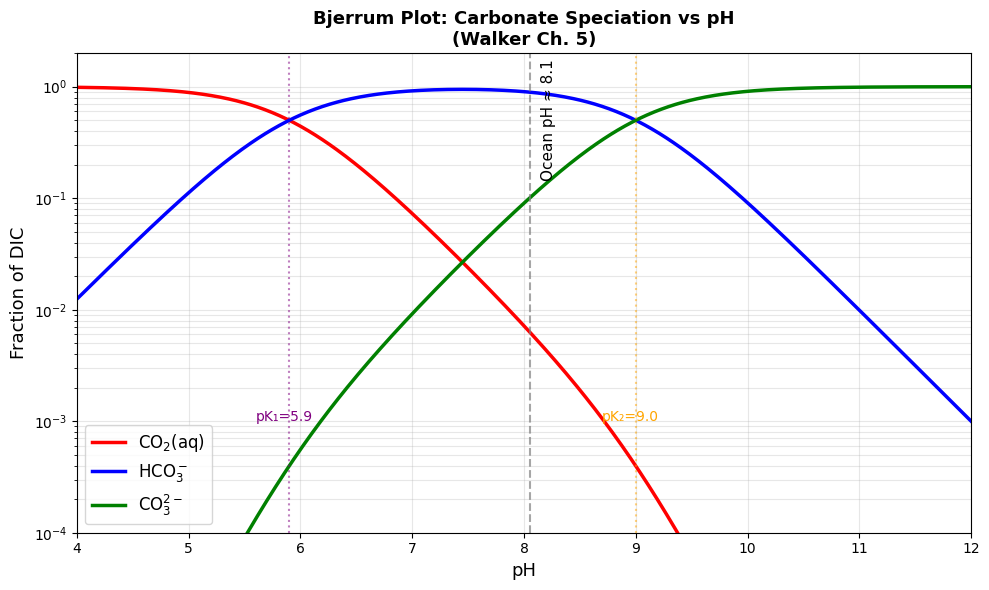

In [4]:
# Bjerrum plot: ionisation fractions as a function of pH
pH_range = np.linspace(4, 12, 500)
h_range = 10.0**(-pH_range)

denom = h_range**2 + K1 * h_range + K1 * K2
f_CO2 = h_range**2 / denom
f_HCO3 = K1 * h_range / denom
f_CO3 = K1 * K2 / denom

fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogy(pH_range, f_CO2, 'r-', linewidth=2.5, label=r'CO$_2$(aq)')
ax.semilogy(pH_range, f_HCO3, 'b-', linewidth=2.5, label=r'HCO$_3^-$')
ax.semilogy(pH_range, f_CO3, 'g-', linewidth=2.5, label=r'CO$_3^{2-}$')

# Mark typical ocean pH
ax.axvline(x=spec['pH'], color='gray', linestyle='--', alpha=0.7)
ax.text(spec['pH'] + 0.1, 0.5, f'Ocean pH ≈ {spec["pH"]:.1f}',
        fontsize=11, rotation=90, va='center')

# Mark pK1 and pK2
ax.axvline(x=-np.log10(K1), color='purple', linestyle=':', alpha=0.5)
ax.text(-np.log10(K1) - 0.3, 1e-3, f'pK₁={-np.log10(K1):.1f}', fontsize=10, color='purple')
ax.axvline(x=-np.log10(K2), color='orange', linestyle=':', alpha=0.5)
ax.text(-np.log10(K2) - 0.3, 1e-3, f'pK₂={-np.log10(K2):.1f}', fontsize=10, color='orange')

ax.set_xlabel('pH', fontsize=13)
ax.set_ylabel('Fraction of DIC', fontsize=13)
ax.set_title('Bjerrum Plot: Carbonate Speciation vs pH\n'
             '(Walker Ch. 5)', fontsize=13, fontweight='bold')
ax.legend(fontsize=12)
ax.set_ylim(1e-4, 2)
ax.set_xlim(4, 12)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

At ocean pH (~8.2), the system sits between pK₁ and pK₂, in the bicarbonate-dominated regime. This is critical: added CO₂ reacts with CO₃²⁻ to form HCO₃⁻, so the *dissolved* CO₂ increases only slightly. This is the chemical basis of the buffer effect.

---

## 5.5 Useful Procedure 2: The Revelle factor from first principles

In Chapter 4 we used the Revelle factor as a given parameter ($\xi \approx 10$). Now we can derive it from the carbonate chemistry. The Revelle factor is defined as:

$$
R = \frac{\partial \ln pCO_2}{\partial \ln \text{DIC}}\bigg|_{\text{Alk}}
= \frac{\text{DIC}}{pCO_2} \cdot \frac{\partial pCO_2}{\partial \text{DIC}}\bigg|_{\text{Alk}}
$$

We compute this numerically by perturbing DIC at constant alkalinity and recalculating pCO₂.

In [14]:
def revelle_factor(DIC, Alk, K1=K1, K2=K2, dDIC_frac=1e-4):
    """Compute Revelle factor numerically: R = (DIC/pCO2) * dpCO2/dDIC at constant Alk."""
    dDIC = DIC * dDIC_frac
    spec_plus = carbonate_speciation(DIC + dDIC, Alk, K1, K2)
    spec_minus = carbonate_speciation(DIC - dDIC, Alk, K1, K2)
    spec_0 = carbonate_speciation(DIC, Alk, K1, K2)
    
    dpCO2_dDIC = (spec_plus['pCO2'] - spec_minus['pCO2']) / (2 * dDIC)
    R = (DIC / spec_0['pCO2']) * dpCO2_dDIC
    return R

R0 = revelle_factor(DIC_0, Alk_0)
print(f"Revelle factor at DIC = {DIC_0*1e6:.0f}, Alk = {Alk_0*1e6:.0f}: R = {R0:.2f}")
print(f"\nThis means: a 1% increase in DIC causes a {R0:.1f}% increase in pCO₂.")

Revelle factor at DIC = 2100, Alk = 2300: R = 13.16

This means: a 1% increase in DIC causes a 13.2% increase in pCO₂.


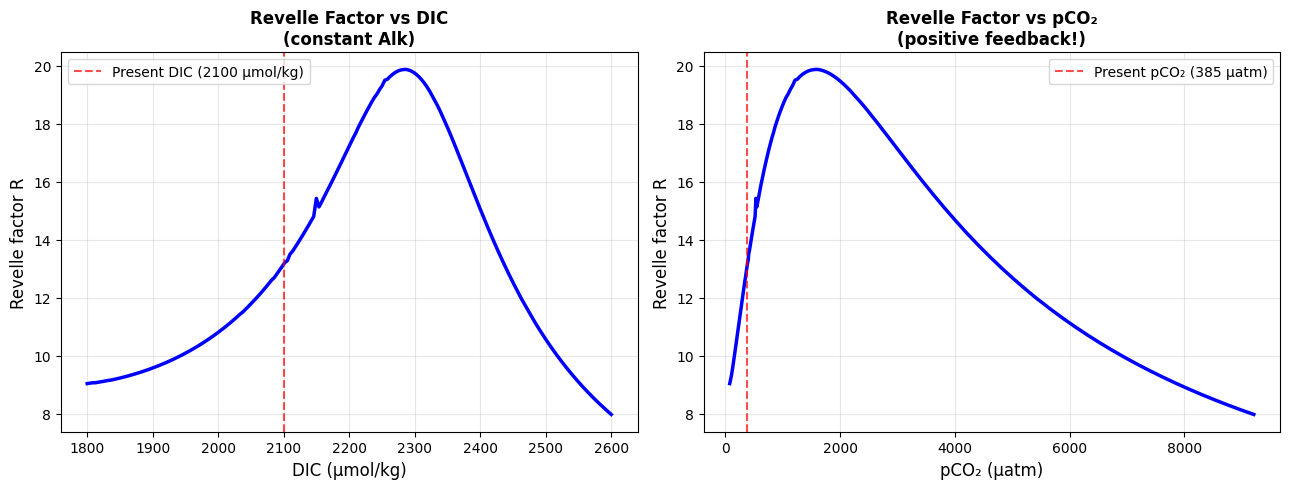

As CO₂ rises, R increases — the ocean becomes a WORSE buffer.
R at DIC=2100: 13.2
R at DIC=2300: 19.7
R at DIC=2500: 10.6


In [15]:
# How does R vary with DIC (at constant Alk)? — i.e. as CO2 is absorbed
DIC_range = np.linspace(1.8e-3, 2.6e-3, 200)
R_range = [revelle_factor(d, Alk_0) for d in DIC_range]
pH_range_dic = [carbonate_speciation(d, Alk_0)['pH'] for d in DIC_range]
pCO2_range = [carbonate_speciation(d, Alk_0)['pCO2'] * 1e6 for d in DIC_range]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(DIC_range * 1e6, R_range, 'b-', linewidth=2.5)
ax1.axvline(x=DIC_0 * 1e6, color='red', linestyle='--', alpha=0.7,
            label=f'Present DIC ({DIC_0*1e6:.0f} μmol/kg)')
ax1.set_xlabel('DIC (μmol/kg)', fontsize=12)
ax1.set_ylabel('Revelle factor R', fontsize=12)
ax1.set_title('Revelle Factor vs DIC\n(constant Alk)',
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(pCO2_range, R_range, 'b-', linewidth=2.5)
ax2.axvline(x=spec['pCO2'] * 1e6, color='red', linestyle='--', alpha=0.7,
            label=f'Present pCO₂ ({spec["pCO2"]*1e6:.0f} μatm)')
ax2.set_xlabel('pCO₂ (μatm)', fontsize=12)
ax2.set_ylabel('Revelle factor R', fontsize=12)
ax2.set_title('Revelle Factor vs pCO₂\n(positive feedback!)',
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"As CO₂ rises, R increases — the ocean becomes a WORSE buffer.")
print(f"R at DIC=2100: {revelle_factor(2.1e-3, Alk_0):.1f}")
print(f"R at DIC=2300: {revelle_factor(2.3e-3, Alk_0):.1f}")
print(f"R at DIC=2500: {revelle_factor(2.5e-3, Alk_0):.1f}")

Important result: **the Revelle factor increases as CO₂ rises**. This is a **positive feedback**; the more CO₂ the ocean absorbs, the *less* able it is to absorb more. The buffering capacity degrades as the carbonate ion is consumed.

---

## 5.6 Useful Procedure 3: Atmosphere-Ocean CO₂ equilibrium

Given the total carbon in the atmosphere + ocean system and the alkalinity, compute the equilibrium partitioning. This uses Newton-Raphson (from Ch. 4) combined with the speciation procedure above.

The equilibrium conditions are:

$$
\begin{aligned}
pCO_2^{\text{atm}} &= pCO_2^{\text{ocean}}(\text{DIC}, \text{Alk}) \\
M_a \cdot pCO_2^{\text{atm}} + V_{\text{ocean}} \cdot \text{DIC} &= C_{\text{total}}
\end{aligned}
$$

where $M_a$ converts atmospheric pCO₂ to moles and $V_{\text{ocean}}$ is the ocean volume in kg.

In [7]:
# ============================================================
# Physical constants for the global system
# ============================================================
pCO2_preind = 280e-6      # preindustrial pCO₂ (atm)
V_ocean = 1.36e21         # ocean mass (kg)
mol_atm = 1.77e20         # moles of air in atmosphere

# Atmospheric CO2 in moles = pCO2 * mol_atm
N_a_preind = pCO2_preind * mol_atm  # ≈ 5.0e16 mol

# Oceanic DIC in moles
N_o_preind = DIC_0 * V_ocean         # ≈ 2.9e18 mol

print(f"Preindustrial atmosphere: {N_a_preind:.2e} mol CO₂ ({N_a_preind*12/1e15:.0f} GtC)")
print(f"Preindustrial ocean:     {N_o_preind:.2e} mol DIC ({N_o_preind*12/1e15:.0f} GtC)")
print(f"Ocean/atmosphere ratio:  {N_o_preind/N_a_preind:.0f}")

Preindustrial atmosphere: 4.96e+16 mol CO₂ (595 GtC)
Preindustrial ocean:     2.86e+18 mol DIC (34272 GtC)
Ocean/atmosphere ratio:  58


In [8]:
def find_equilibrium_chemistry(C_total_mol, Alk, V_ocean, mol_atm, K0, K1, K2):
    """Find atmosphere-ocean equilibrium using Newton-Raphson.
    
    Solves for DIC such that:
      pCO2(DIC, Alk) * mol_atm + DIC * V_ocean = C_total_mol
    """
    # Initial guess: current DIC
    DIC = C_total_mol / (V_ocean + mol_atm * K0)  # rough guess
    
    for k in range(50):
        spec = carbonate_speciation(DIC, Alk, K1, K2)
        pCO2 = spec['pCO2']
        
        # Residual: total C - (atm + ocean)
        g = mol_atm * pCO2 + V_ocean * DIC - C_total_mol
        
        # Derivative: dg/dDIC = mol_atm * dpCO2/dDIC + V_ocean
        dDIC = DIC * 1e-6
        spec_p = carbonate_speciation(DIC + dDIC, Alk, K1, K2)
        dpCO2_dDIC = (spec_p['pCO2'] - pCO2) / dDIC
        dg = mol_atm * dpCO2_dDIC + V_ocean
        
        DIC_new = DIC - g / dg
        if abs(DIC_new - DIC) / DIC < 1e-12:
            return DIC_new, k + 1
        DIC = DIC_new
    
    return DIC, 50

---

## 5.7 Experiment 1: Fossil fuel CO₂, where does it go?

We add fossil fuel CO₂ to the atmosphere-ocean system and compute the equilibrium redistribution using the real carbonate chemistry, replacing the power-law approximation from Chapter 4.

In [9]:
# Scan: add varying amounts of fossil fuel CO2 and find new equilibrium
additions_GtC = np.linspace(0, 5000, 50)  # GtC added
additions_mol = additions_GtC * 1e15 / 12  # convert to mol

C_total_preind = N_a_preind + N_o_preind

pCO2_results = []
DIC_results = []
pH_results = []
R_results = []
airborne_results = []

for add_mol in additions_mol:
    C_total = C_total_preind + add_mol
    DIC_eq, _ = find_equilibrium_chemistry(C_total, Alk_0, V_ocean, mol_atm, K0, K1, K2)
    spec_eq = carbonate_speciation(DIC_eq, Alk_0)
    
    pCO2_results.append(spec_eq['pCO2'] * 1e6)  # μatm
    DIC_results.append(DIC_eq * 1e6)             # μmol/kg
    pH_results.append(spec_eq['pH'])
    R_results.append(revelle_factor(DIC_eq, Alk_0))
    
    # Airborne fraction: (new atm - old atm) / added
    if add_mol > 0:
        new_atm_mol = spec_eq['pCO2'] * mol_atm
        af = (new_atm_mol - N_a_preind) / add_mol
        airborne_results.append(af)
    else:
        airborne_results.append(0)

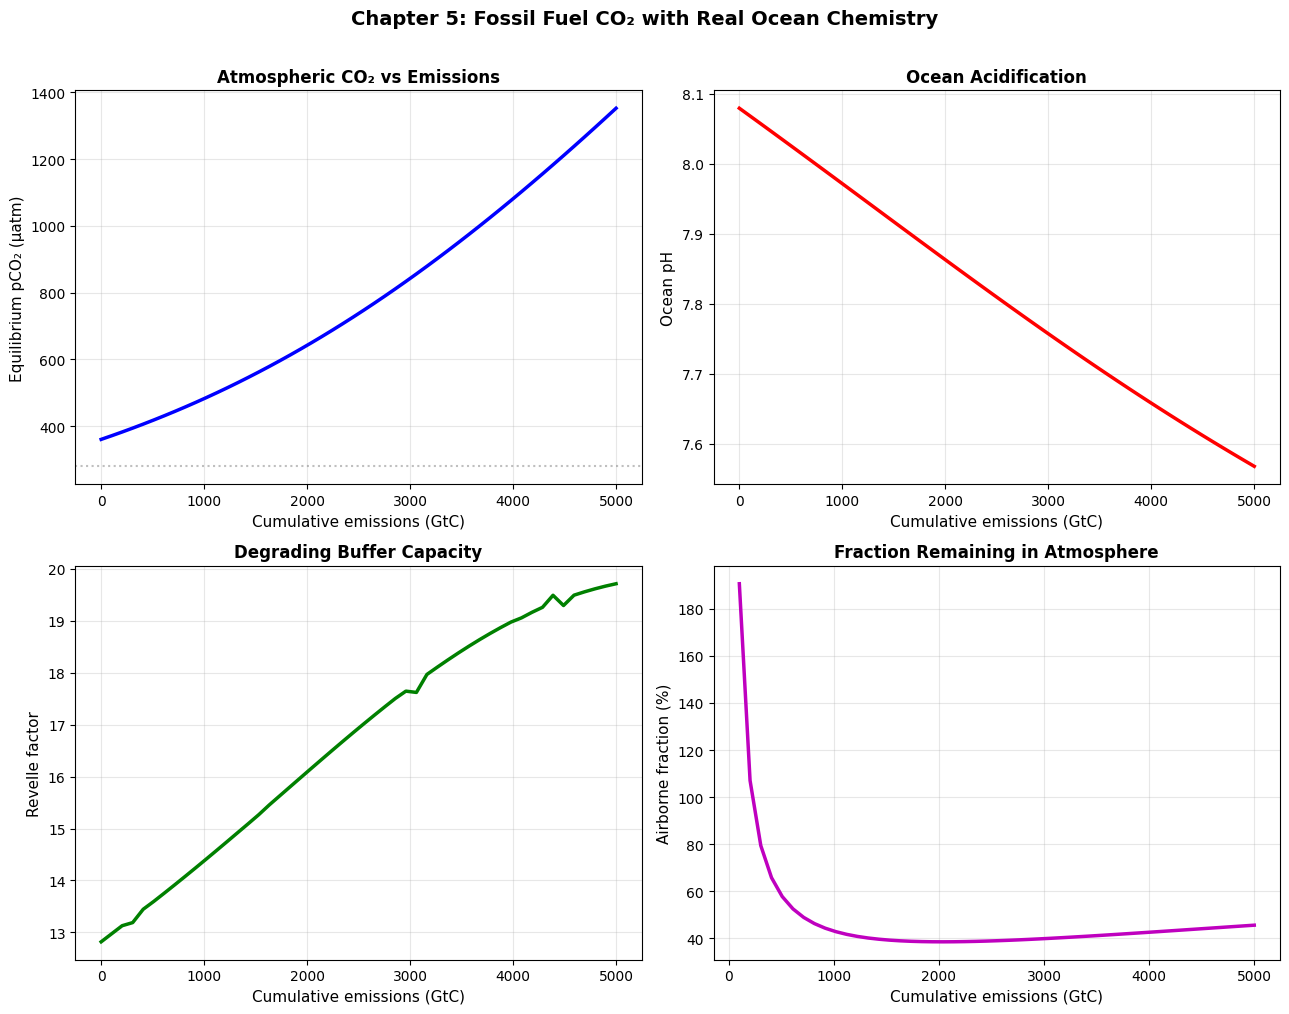

      0 GtC: pCO₂ =    361 μatm, pH = 8.08, R = 12.8, airborne = 0.0%
    510 GtC: pCO₂ =    419 μatm, pH = 8.02, R = 13.6, airborne = 57.7%
   1020 GtC: pCO₂ =    486 μatm, pH = 7.97, R = 14.4, airborne = 42.8%
   2041 GtC: pCO₂ =    650 μatm, pH = 7.86, R = 16.2, airborne = 38.5%
   5000 GtC: pCO₂ =   1353 μatm, pH = 7.57, R = 19.7, airborne = 45.6%


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

ax = axes[0, 0]
ax.plot(additions_GtC, pCO2_results, 'b-', linewidth=2.5)
ax.axhline(y=280, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Cumulative emissions (GtC)', fontsize=11)
ax.set_ylabel('Equilibrium pCO₂ (μatm)', fontsize=11)
ax.set_title('Atmospheric CO₂ vs Emissions', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(additions_GtC, pH_results, 'r-', linewidth=2.5)
ax.set_xlabel('Cumulative emissions (GtC)', fontsize=11)
ax.set_ylabel('Ocean pH', fontsize=11)
ax.set_title('Ocean Acidification', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.plot(additions_GtC, R_results, 'g-', linewidth=2.5)
ax.set_xlabel('Cumulative emissions (GtC)', fontsize=11)
ax.set_ylabel('Revelle factor', fontsize=11)
ax.set_title('Degrading Buffer Capacity', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(additions_GtC[1:], [a * 100 for a in airborne_results[1:]], 'm-', linewidth=2.5)
ax.set_xlabel('Cumulative emissions (GtC)', fontsize=11)
ax.set_ylabel('Airborne fraction (%)', fontsize=11)
ax.set_title('Fraction Remaining in Atmosphere', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

fig.suptitle('Chapter 5: Fossil Fuel CO₂ with Real Ocean Chemistry',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Print key values
for target_GtC in [0, 500, 1000, 2000, 5000]:
    idx = np.argmin(np.abs(additions_GtC - target_GtC))
    print(f"  {additions_GtC[idx]:5.0f} GtC: pCO₂ = {pCO2_results[idx]:6.0f} μatm, "
          f"pH = {pH_results[idx]:.2f}, R = {R_results[idx]:.1f}, "
          f"airborne = {airborne_results[idx]*100:.1f}%")

### Key results:

- The relationship between emissions and pCO₂ is **strongly nonlinear**, it curves upward because the buffer degrades.
- **Ocean acidification**: pH drops from ~8.2 to below 7.6 for large emissions.
- The Revelle factor **increases** with emissions (positive feedback).
- The equilibrium airborne fraction **grows** from ~15% to >30% for very large emissions, the ocean becomes progressively less effective as a CO₂ sink.

These results come from the full carbonate chemistry, not the simplified $c^\xi$ approximation of Chapter 4.

---

## 5.8 Experiment 2: Time-dependent uptake with real chemistry

We now combine the time-stepping from Chapters 2–4 with the real carbonate chemistry. The atmosphere exchanges CO₂ with a well-mixed surface ocean (on a timescale $\tau \approx 8.6$ yr), and pCO₂ in the ocean is computed from the full speciation.

For simplicity, we treat the ocean as a single box (deferring the multi-box treatment to when we combine Chapters 3 and 5).

In [11]:
# ============================================================
# Time-dependent model with real carbonate chemistry
# ============================================================

tau_ex = 8.6  # atmosphere-ocean exchange timescale (yr)

def co2_system_real(t, y):
    """ODE system with real ocean carbonate chemistry.
    
    State: y = [N_a, N_o]  (moles of C in atmosphere and ocean)
    """
    N_a, N_o = y
    
    # Atmospheric pCO2
    pCO2_atm = N_a / mol_atm  # atm
    
    # Oceanic DIC and pCO2
    DIC = N_o / V_ocean  # mol/kg
    spec = carbonate_speciation(DIC, Alk_0)
    pCO2_ocean = spec['pCO2']  # atm
    
    # Net flux: proportional to pCO2 difference
    # F = (pCO2_atm - pCO2_ocean) * mol_atm / tau
    F_net = (pCO2_atm - pCO2_ocean) * mol_atm / tau_ex  # mol/yr, atm→ocean
    
    dNa = -F_net
    dNo = F_net
    return [dNa, dNo]

# Initial condition: instantaneous doubling of atmosphere
N_a_init = 2 * N_a_preind  # doubled atmosphere
N_o_init = N_o_preind       # ocean unchanged

t_end = 1000.0
sol = solve_ivp(co2_system_real, [0, t_end], [N_a_init, N_o_init],
                method='Radau', rtol=1e-10, atol=1e-10,
                dense_output=True, max_step=2.0)

t_plot = np.linspace(0, t_end, 1000)
y_plot = sol.sol(t_plot)

# Convert to pCO2 and pH
pCO2_t = y_plot[0] / mol_atm * 1e6  # μatm
pH_t = np.array([carbonate_speciation(N_o / V_ocean, Alk_0)['pH']
                 for N_o in y_plot[1]])

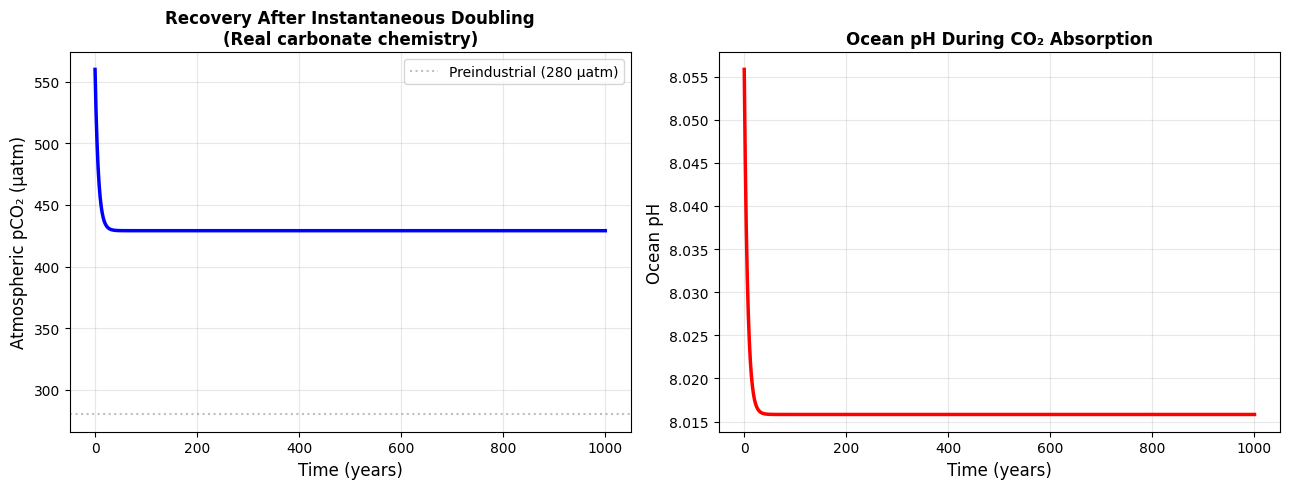

Initial: pCO₂ = 560 μatm, pH = 8.06
Final:   pCO₂ = 429 μatm, pH = 8.02
Airborne fraction: 53.3%


In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(t_plot, pCO2_t, 'b-', linewidth=2.5)
ax1.axhline(y=280, color='gray', linestyle=':', alpha=0.5, label='Preindustrial (280 μatm)')
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('Atmospheric pCO₂ (μatm)', fontsize=12)
ax1.set_title('Recovery After Instantaneous Doubling\n(Real carbonate chemistry)',
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(t_plot, pH_t, 'r-', linewidth=2.5)
ax2.set_xlabel('Time (years)', fontsize=12)
ax2.set_ylabel('Ocean pH', fontsize=12)
ax2.set_title('Ocean pH During CO₂ Absorption',
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial: pCO₂ = {pCO2_t[0]:.0f} μatm, pH = {pH_t[0]:.2f}")
print(f"Final:   pCO₂ = {pCO2_t[-1]:.0f} μatm, pH = {pH_t[-1]:.2f}")
print(f"Airborne fraction: {(pCO2_t[-1] - 280) / (560 - 280):.1%}")

The final pCO₂ settles well above the preindustrial level, this is the Revelle effect in action with the real chemistry. Compare this with Chapter 2's linear model, which predicted a return to equilibrium, and Chapter 4's power-law approximation.

---

## 5.9 Experiment 3: Comparing the three models

Let us place all three approaches side by side: the linear model (Ch. 2), the power-law Revelle approximation (Ch. 4), and the full chemistry (Ch. 5).

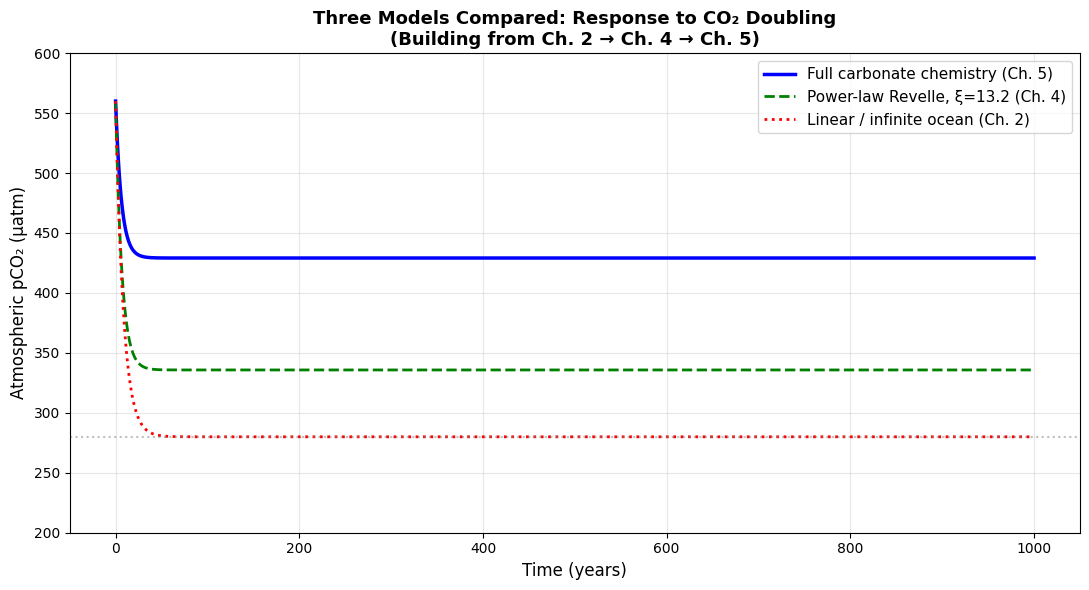

Equilibrium pCO₂:
  Linear (Ch.2):     280 μatm (airborne: 0.0%)
  Power-law (Ch.4):  336 μatm (airborne: 19.9%)
  Full chem (Ch.5):  429 μatm (airborne: 53.3%)


In [13]:
# Model 1: Linear (Chapter 2 style — ocean as infinite reservoir)
def linear_model(t, y):
    pCO2 = y[0] / mol_atm
    F = (pCO2 - pCO2_preind) * mol_atm / tau_ex
    return [-F]

sol_lin = solve_ivp(linear_model, [0, t_end], [N_a_init],
                    dense_output=True, rtol=1e-10)
pCO2_lin = sol_lin.sol(t_plot)[0] / mol_atm * 1e6

# Model 2: Power-law Revelle (Chapter 4 style)
xi_ch4 = R0  # use the Revelle factor we computed
mu_ch4 = N_a_preind / N_o_preind

def powerlaw_model(t, y):
    N_a, N_o = y
    p = N_a / N_a_preind  # normalised atm
    c = N_o / N_o_preind  # normalised ocean
    flux = (c**xi_ch4 - p) / tau_ex * N_a_preind  # mol/yr
    return [flux, -flux]

sol_pl = solve_ivp(powerlaw_model, [0, t_end], [N_a_init, N_o_init],
                   method='Radau', dense_output=True, rtol=1e-10, max_step=2.0)
pCO2_pl = sol_pl.sol(t_plot)[0] / mol_atm * 1e6

# Model 3: Real chemistry (already computed above)

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(t_plot, pCO2_t, 'b-', linewidth=2.5, label='Full carbonate chemistry (Ch. 5)')
ax.plot(t_plot, pCO2_pl, 'g--', linewidth=2, label=f'Power-law Revelle, ξ={xi_ch4:.1f} (Ch. 4)')
ax.plot(t_plot, pCO2_lin, 'r:', linewidth=2, label='Linear / infinite ocean (Ch. 2)')

ax.axhline(y=280, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Atmospheric pCO₂ (μatm)', fontsize=12)
ax.set_title('Three Models Compared: Response to CO₂ Doubling\n'
             '(Building from Ch. 2 → Ch. 4 → Ch. 5)',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(200, 600)
plt.tight_layout()
plt.show()

print(f"Equilibrium pCO₂:")
print(f"  Linear (Ch.2):     {pCO2_lin[-1]:.0f} μatm (airborne: {(pCO2_lin[-1]-280)/280:.1%})")
print(f"  Power-law (Ch.4):  {pCO2_pl[-1]:.0f} μatm (airborne: {(pCO2_pl[-1]-280)/280:.1%})")
print(f"  Full chem (Ch.5):  {pCO2_t[-1]:.0f} μatm (airborne: {(pCO2_t[-1]-280)/280:.1%})")

This comparison shows the progression through Walker's book: each chapter adds physical realism that changes the answer fundamentally. The linear model is wildly optimistic, the power-law captures the first-order effect, and the full chemistry adds important detail (especially at large perturbations where the Revelle factor itself changes).

---

## 5.10 Exercises

**Exercise 5.1:** Add temperature dependence. The dissociation constants $K_1$ and $K_2$ depend on temperature (and salinity). Using Lueker et al. (2000) or Millero (1995) parameterisations, compute how the Revelle factor and equilibrium airborne fraction change with ocean temperature. How does ocean warming affect CO₂ uptake?

**Exercise 5.2:** Include borate alkalinity. The full alkalinity is $\text{Alk} = [\text{HCO}_3^-] + 2[\text{CO}_3^{2-}] + [\text{B(OH)}_4^-] + [\text{OH}^-] - [\text{H}^+]$. How much does including borate change the Revelle factor?

**Exercise 5.3:** Combine with Chapter 3's multi-box model. Use a surface ocean box (with real carbonate chemistry and atmosphere exchange) coupled to a deep ocean box (with mixing only). How does the two-box time response differ from the single-box model above?

**Exercise 5.4:** Compute the ocean's **CaCO₃ saturation state** $\Omega = [\text{Ca}^{2+}][\text{CO}_3^{2-}]/K_{sp}$ as a function of cumulative emissions. At what emission level does the surface ocean become undersaturated with respect to aragonite?

**Exercise 5.5:** Walker discusses the effect of CaCO₃ dissolution as a long-term neutralisation mechanism. If ocean acidification dissolves seafloor CaCO₃, this adds alkalinity and DIC in a 2:1 ratio. Implement this as an additional slow process and show how it enhances CO₂ uptake on timescales of thousands of years.

---

## References

- Walker, J.C.G. (1991). *Numerical Adventures with Geochemical Cycles*. Oxford University Press. Chapter 5: "The Carbon System and Several Useful Procedures."
- Broecker, W.S. and Peng, T.-H. (1982). *Tracers in the Sea*. Eldigio Press, Palisades, New York.
- Revelle, R. and Suess, H.E. (1957). Carbon dioxide exchange between atmosphere and ocean. *Tellus*, 9, 18–27.
- Egleston, E.S., Sabine, C.L., and Morel, F.M.M. (2010). Revelle revisited. *Global Biogeochem. Cycles*, 24, GB1002.
- Zeebe, R.E. and Wolf-Gladrow, D. (2001). *CO₂ in Seawater: Equilibrium, Kinetics, Isotopes*. Elsevier.